<a href="https://colab.research.google.com/github/deepro2811/MultimodalFinancialDataModelling/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# If using Drive in Colab, mount first:
# from google.colab import drive
# drive.mount('/content/drive')

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression

# Path to your preprocessed file
CSV = "/content/features_preprocessed.csv"  # <-- change if needed

df = pd.read_csv(CSV, parse_dates=["week_start"])
df = df.sort_values(["week_start","symbol"]).reset_index(drop=True)

ID_COLS  = ["symbol","week_start"]
TARGET   = "ret_fwd_1w"
PREDICTORS = [
    'ret_csrz','log_ret_csrz','mom_4w_csrz','vol_12w_csrz',
    'sent_mean_lag1_csrz','sent_std_lag1_csrz',
    'news_count_lag1_log1p_csz','is_pos_sum_lag1_log1p_csz','is_neg_sum_lag1_log1p_csz','sources_n_lag1_log1p_csz',
    'sent_mean_missing_lag1',
    'xret_mean_t_csrz','xret_median_t_csrz','xret_std_t_csrz','breadth_t_csrz'
]
# Keep only columns that actually exist (defensive)
PREDICTORS = [c for c in PREDICTORS if c in df.columns]
print("Rows:", len(df), "Symbols:", df.symbol.nunique(), "Weeks:", df.week_start.nunique())
print("Predictors:", PREDICTORS)


Rows: 6660 Symbols: 148 Weeks: 45
Predictors: ['ret_csrz', 'log_ret_csrz', 'mom_4w_csrz', 'vol_12w_csrz', 'sent_mean_lag1_csrz', 'sent_std_lag1_csrz', 'news_count_lag1_log1p_csz', 'is_pos_sum_lag1_log1p_csz', 'is_neg_sum_lag1_log1p_csz', 'sources_n_lag1_log1p_csz', 'sent_mean_missing_lag1', 'xret_mean_t_csrz', 'xret_median_t_csrz', 'xret_std_t_csrz', 'breadth_t_csrz']


## **Coverage & basic target behavior**





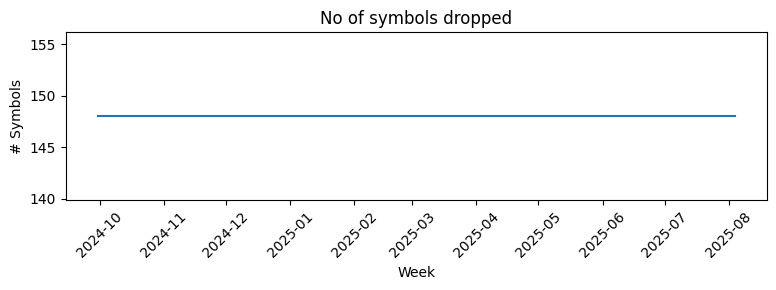

In [7]:
# Coverage: names per week
wk_cov = df.groupby("week_start")["symbol"].nunique()
plt.figure(figsize=(8,3))
plt.plot(wk_cov.index, wk_cov.values)
plt.title("No of symbols dropped")
plt.xlabel("Week")
plt.ylabel("# Symbols")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

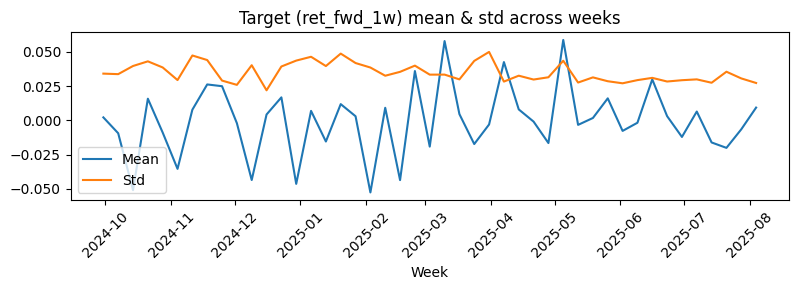

In [8]:
# Target dispersion per week (mean & std)
wk_stats = df.groupby("week_start")[TARGET].agg(['mean','std'])
plt.figure(figsize=(8,3))
plt.plot(wk_stats.index, wk_stats['mean'].values, label="Mean")
plt.plot(wk_stats.index, wk_stats['std'].values,  label="Std")
plt.title("Target (ret_fwd_1w) mean & std across weeks")
plt.xlabel("Week"); plt.legend()
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

Mean (blue) = the cross-sectional average next-week return across all stocks in that week.

~0 most of the time is normal for weekly equity returns.

Sustained >0 or <0 stretches = bullish/bearish drift in that period.

Std (orange) = the cross-sectional dispersion of next-week returns within that week.

High spikes ⇒ big spread between winners and losers (risk is up, but alpha opportunity for long/short is also higher).

Low troughs ⇒ a flat market cross-section (harder to differentiate names; signals may look weaker).

Why it’s useful for modeling

Shows non-stationarity and heteroskedasticity in the target. That justifies:

Adding regime controls (we did: xret_*_t_csrz, breadth_t_csrz).

Using rank-based evaluation (weekly rank-IC) alongside MAE/MSE.

Optional per-week reweighting (don’t let high-volatility weeks dominate training).

## **Cross-section histograms (latest week snapshot)** ##

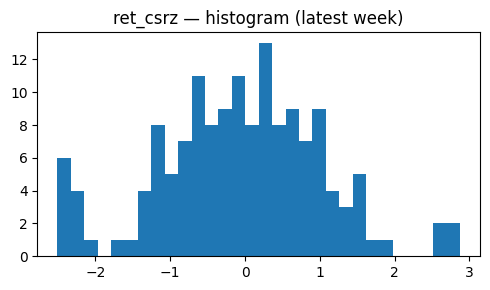

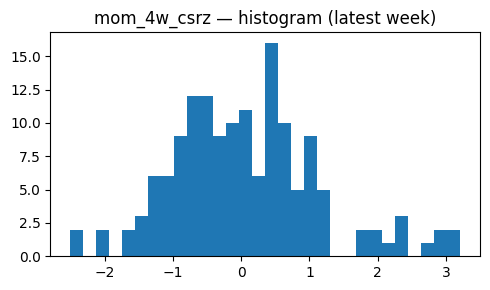

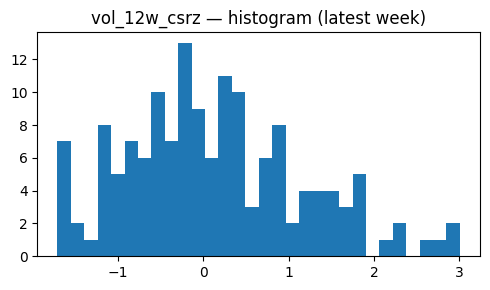

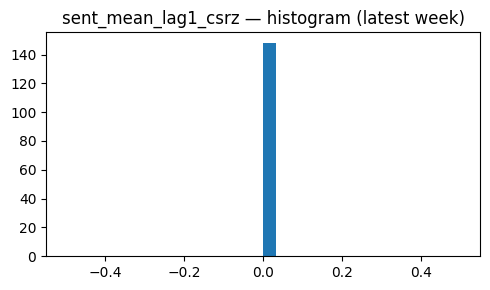

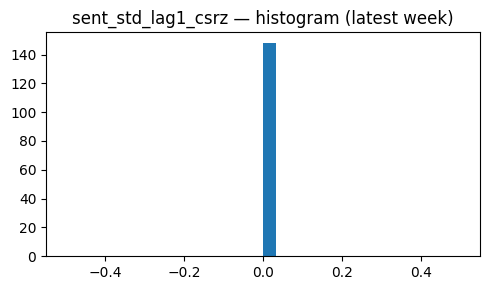

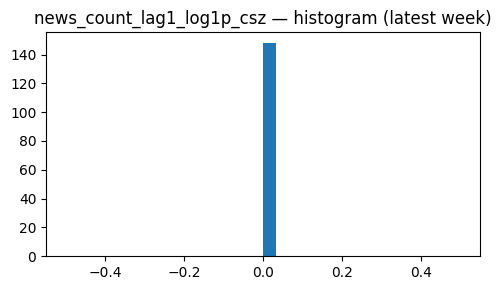

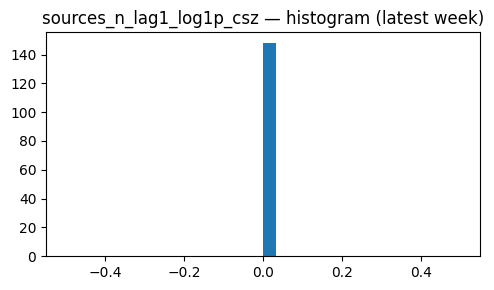

In [9]:
latest = df["week_start"].max()
snap = df[df.week_start==latest]

cols_to_plot = [c for c in [
    'ret_csrz','mom_4w_csrz','vol_12w_csrz',
    'sent_mean_lag1_csrz','sent_std_lag1_csrz',
    'news_count_lag1_log1p_csz','sources_n_lag1_log1p_csz'
] if c in df.columns]

for c in cols_to_plot:
    plt.figure(figsize=(5,3))
    plt.hist(snap[c].dropna().values, bins=30)
    plt.title(f"{c} — histogram (latest week)")
    plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


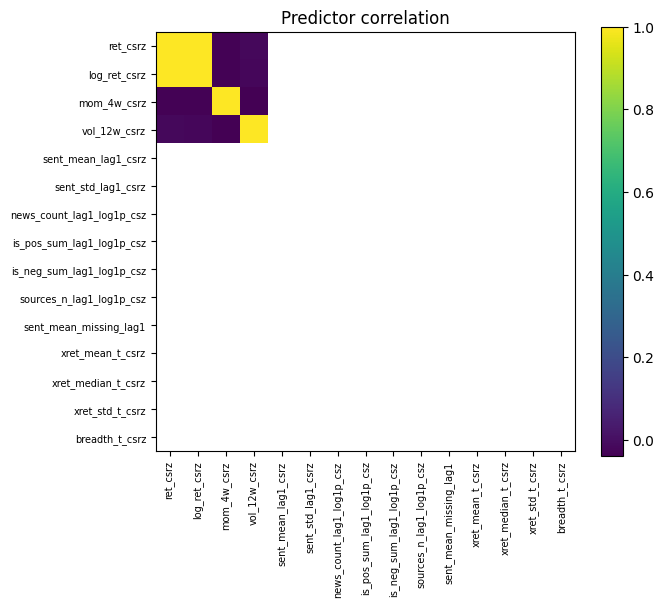

In [10]:
X = df[PREDICTORS].values
corr = np.corrcoef(X, rowvar=False)

plt.figure(figsize=(7,6))
plt.imshow(corr, interpolation='nearest')
plt.title("Predictor correlation")
plt.xticks(range(len(PREDICTORS)), PREDICTORS, rotation=90, fontsize=7)
plt.yticks(range(len(PREDICTORS)), PREDICTORS, fontsize=7)
plt.colorbar(); plt.tight_layout(); plt.show()
